In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from ruzicka.test_metrics import minmax
from ruzicka.test_metrics import cosine

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

In [308]:
stops_tidy = pd.read_csv("../data/arist_corpus.csv", index_col=0)
stops_tidy = stops_tidy[stops_tidy.Translator != "Myst"]
stops_tidy

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,EthV,duplici autem virtute existente hac quidem int...,0.000000,0.062338,0.685717,0.0,0.0,0.0,0.020779,...,0.207793,0.000000,0.0,0.000000,0.207793,0.041559,0.0,0.0,0.145455,0.0
1,Bur,EthV,malicia autem contrarium fiet autem nobis et e...,0.000000,0.049793,0.813285,0.0,0.0,0.0,0.000000,...,0.165977,0.000000,0.0,0.000000,0.016598,0.066391,0.0,0.0,0.066391,0.0
2,Bur,EthV,bene habentibus operis quoniam neque auferendu...,0.000000,0.000000,0.896433,0.0,0.0,0.0,0.011493,...,0.034478,0.000000,0.0,0.000000,0.091942,0.011493,0.0,0.0,0.045971,0.0
3,Bur,EthV,et medietas amicicia qui superhabundat autem q...,0.000000,0.064567,0.774798,0.0,0.0,0.0,0.000000,...,0.096850,0.000000,0.0,0.000000,0.080708,0.064567,0.0,0.0,0.032283,0.0
4,Bur,EthV,iacit volens in salute autem sui ipsius et rel...,0.000000,0.150855,0.822845,0.0,0.0,0.0,0.054856,...,0.013714,0.000000,0.0,0.000000,0.095999,0.123427,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,Anon,Metaph,palam nec enim impar infinitus est nec par gen...,0.025294,0.328824,0.227648,0.0,0.0,0.0,0.000000,...,0.126471,0.075883,0.0,0.075883,0.430001,0.000000,0.0,0.0,0.455295,0.0
1210,Anon,Metaph,aut non quare eadem accident et sic aut enim n...,0.000000,0.298142,0.238514,0.0,0.0,0.0,0.059628,...,0.089443,0.000000,0.0,0.000000,0.268328,0.000000,0.0,0.0,0.566471,0.0
1211,Anon,Metaph,quidem potentia illud vero actu ergo potentia ...,0.000000,0.380143,0.253429,0.0,0.0,0.0,0.050686,...,0.050686,0.000000,0.0,0.025343,0.456172,0.000000,0.0,0.0,0.481514,0.0
1212,Anon,Metaph,tempori non finis est non etiam erit sempitern...,0.030331,0.242647,0.242647,0.0,0.0,0.0,0.060662,...,0.060662,0.060662,0.0,0.000000,0.121324,0.000000,0.0,0.0,0.454963,0.0


In [343]:
stops_tidy.loc[stops_tidy.Work == "Rhet1", "Work"] = "Rhet"

In [344]:
feat_cols = stops_tidy.columns[3:]

In [310]:
def balanced_subsample(
    y, size=None, rng: np.random.Generator = np.random.default_rng()
):
    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = rng.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample


def bootstrap_imposters(
    test_vec: NDArray[float],
    X: NDArray[NDArray[float]],
    y: NDArray[int],
    cand_idx: int,
    n: int,
    pct: float,
    dist_fn: Callable[[NDArray[float], NDArray[float]], float],
    method: str = "random",
    rng: np.random.Generator = np.random.default_rng(),
    balance: bool = False,
) -> list[float]:
    # X at the row indices where y matches the condition
    candidates = X[(y == cand_idx).nonzero()]
    others = X[(y != cand_idx).nonzero()]
    differences: list[float] = []
    cand_samps: NDArray[float] = []
    other_samps: NDArray[float] = []
    pdy = pd.Series(y)
    if method == "random":
        # choose n random row indices with replacement, all columns. This will
        # still work if n > num_candidates because it will oversample.
        cand_samps = candidates[rng.choice(candidates.shape[0], n, replace=True), :]
        other_samps = others[rng.choice(others.shape[0], n, replace=True), :]

    # At each bootstrap iteration we choose a different feature subset
    for i in range(n * 2):
        if balance:
            # Balances the sample down to the least abundant class
            ss = balanced_subsample(pdy, rng=rng)  # indices into y
            candidates = X[np.where(y[ss] == cand_idx)]
            others = X[np.where(y[ss] != cand_idx)]
        try:
            # This try is to catch subsamples from sparse data where some column
            # subsets are just empty and so the distance metrics yield divzero.
            # We try for n*2 iterations, returning early when we have n and
            # raising if we don't get there.

            # from 1d vectors, choose (pct * width_of_X) random column indices (no
            # replacement)
            ridx = rng.choice(X.shape[1], int(X.shape[1] * pct), replace=False)

            # compare the test vector to one in-sample and one outsample (with
            # bootstrap columns), then record the difference of distances
            if method == "random":
                in_dist = dist_fn(test_vec[ridx], cand_samps[i][ridx])
                out_dist = dist_fn(test_vec[ridx], other_samps[i][ridx])
                differences.append(out_dist - in_dist)

            # compare the test vector to the closest in-sample and out-sample, then
            # record the difference of distances (like vanilla Kestemont GI)
            elif method == "closest":
                in_dists = [
                    dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
                ]
                out_dists = [
                    dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
                ]
                differences.append(min(out_dists) - min(in_dists))

            # compare the test vector to the closest in-sample and out-sample, then
            # record the scaled difference of distances for the smallest 3 (like
            # Kestemont GI with Eder Boostrap Consensus Tree stye ranking)
            elif method == "ranked":
                in_dists = [
                    dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
                ]
                out_dists = [
                    dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
                ]

                # faster than sorting and slicing
                top_in = heapq.nsmallest(3, in_dists)
                top_out = heapq.nsmallest(3, out_dists)
                d = 0
                for nn in range(3):
                    # smallest distances are unscaled, seccond is halved, etc
                    d += (top_out[nn] - top_in[nn]) / (nn + 1)
                differences.append(d)
            else:
                raise ValueError(
                    f"Unsupported method {method}, valid are: random, closest, ranked"
                )
        except ZeroDivisionError:
            continue
        if len(differences) >= n:
            return differences
    raise ValueError("Too many ZeroDivisionErrors. Data too sparse?")

In [345]:
problems = (
    stops_tidy[stops_tidy.Work.str.startswith("Rhet")].reset_index(drop=True).copy()
)
problems

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bxx,Rhet,rethorica est convertibilis dialetice utreque ...,0.0,0.394042,0.497737,0.000000,0.0,0.000000,0.020739,...,0.062217,0.041478,0.0,0.020739,0.165912,0.228129,0.000000,0.0,0.331825,0.0
1,Bxx,Rhet,iuverit maxime utens iuste et leserit iniuste ...,0.0,0.277810,0.590345,0.000000,0.0,0.000000,0.052089,...,0.052089,0.156268,0.0,0.034726,0.121542,0.069452,0.000000,0.0,0.347262,0.0
2,Bxx,Rhet,horum cognitum non oportet dicere ipse enim au...,0.0,0.267038,0.534076,0.000000,0.0,0.000000,0.066759,...,0.050070,0.233658,0.0,0.000000,0.183588,0.066759,0.000000,0.0,0.317107,0.0
3,Bxx,Rhet,quomodo non lesit quoniam autem iniustificat n...,0.0,0.524604,0.671493,0.000000,0.0,0.000000,0.000000,...,0.020984,0.041968,0.0,0.020984,0.104921,0.125905,0.000000,0.0,0.104921,0.0
4,Bxx,Rhet,sunt ex quibus autem oportet et de hiis et ali...,0.0,0.636098,0.371057,0.000000,0.0,0.000000,0.070678,...,0.070678,0.035339,0.0,0.000000,0.088347,0.141355,0.000000,0.0,0.512412,0.0
5,Bxx,Rhet,ut puta quorum natura contingit vero et extra ...,0.0,0.501868,0.259587,0.000000,0.0,0.000000,0.017306,...,0.017306,0.173058,0.0,0.000000,0.173058,0.190364,0.000000,0.0,0.380728,0.0
6,Bxx,Rhet,quidem semper et plus ad minus magnum autem et...,0.0,0.446895,0.169512,0.015410,0.0,0.000000,0.015410,...,0.030820,0.092461,0.0,0.046231,0.123281,0.154102,0.000000,0.0,0.385254,0.0
7,Bxx,Rhet,dicit meleagrum persuaderi ab uxore dicente qu...,0.0,0.279386,0.558772,0.000000,0.0,0.000000,0.059868,...,0.039912,0.099781,0.0,0.019956,0.079825,0.079825,0.000000,0.0,0.439035,0.0
8,Bxx,Rhet,de universali et de partibus dictum est secund...,0.0,0.305869,0.415108,0.000000,0.0,0.000000,0.021848,...,0.043696,0.152935,0.0,0.043696,0.218478,0.174783,0.000000,0.0,0.196630,0.0
9,Bxx,Rhet,enim ex contrariis est de accusatione vero et ...,0.0,0.480519,0.294512,0.015501,0.0,0.000000,0.015501,...,0.000000,0.015501,0.0,0.046502,0.062002,0.108504,0.000000,0.0,0.558022,0.0


In [346]:
problems["Compound"] = problems.apply(
    lambda r: f"{r.Translator}{r.Work}{r.name}", axis=1
)

In [347]:
comparison = (
    stops_tidy[~stops_tidy.Work.str.startswith("Rhet")].reset_index(drop=True).copy()
)
comparison

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,EthV,duplici autem virtute existente hac quidem int...,0.000000,0.062338,0.685717,0.0,0.0,0.0,0.020779,...,0.207793,0.000000,0.0,0.000000,0.207793,0.041559,0.0,0.0,0.145455,0.0
1,Bur,EthV,malicia autem contrarium fiet autem nobis et e...,0.000000,0.049793,0.813285,0.0,0.0,0.0,0.000000,...,0.165977,0.000000,0.0,0.000000,0.016598,0.066391,0.0,0.0,0.066391,0.0
2,Bur,EthV,bene habentibus operis quoniam neque auferendu...,0.000000,0.000000,0.896433,0.0,0.0,0.0,0.011493,...,0.034478,0.000000,0.0,0.000000,0.091942,0.011493,0.0,0.0,0.045971,0.0
3,Bur,EthV,et medietas amicicia qui superhabundat autem q...,0.000000,0.064567,0.774798,0.0,0.0,0.0,0.000000,...,0.096850,0.000000,0.0,0.000000,0.080708,0.064567,0.0,0.0,0.032283,0.0
4,Bur,EthV,iacit volens in salute autem sui ipsius et rel...,0.000000,0.150855,0.822845,0.0,0.0,0.0,0.054856,...,0.013714,0.000000,0.0,0.000000,0.095999,0.123427,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,Anon,Metaph,palam nec enim impar infinitus est nec par gen...,0.025294,0.328824,0.227648,0.0,0.0,0.0,0.000000,...,0.126471,0.075883,0.0,0.075883,0.430001,0.000000,0.0,0.0,0.455295,0.0
1153,Anon,Metaph,aut non quare eadem accident et sic aut enim n...,0.000000,0.298142,0.238514,0.0,0.0,0.0,0.059628,...,0.089443,0.000000,0.0,0.000000,0.268328,0.000000,0.0,0.0,0.566471,0.0
1154,Anon,Metaph,quidem potentia illud vero actu ergo potentia ...,0.000000,0.380143,0.253429,0.0,0.0,0.0,0.050686,...,0.050686,0.000000,0.0,0.025343,0.456172,0.000000,0.0,0.0,0.481514,0.0
1155,Anon,Metaph,tempori non finis est non etiam erit sempitern...,0.030331,0.242647,0.242647,0.0,0.0,0.0,0.060662,...,0.060662,0.060662,0.0,0.000000,0.121324,0.000000,0.0,0.0,0.454963,0.0


In [322]:
comparison[comparison.Translator == "Bar"]

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
9,Bar,Pri,ï»¿ quomodo determinare oportet et quibus spec...,0.0,0.191023,0.694629,0.000000,0.0,0.017366,0.017366,...,0.017366,0.191023,0.000000,0.000000,0.191023,0.434143,0.0,0.0,0.034731,0.000000
10,Bar,Pri,solum plato quidem igitur in reducendo ad prin...,0.0,0.153592,0.829396,0.000000,0.0,0.000000,0.000000,...,0.015359,0.215029,0.000000,0.000000,0.168951,0.215029,0.0,0.0,0.030718,0.000000
345,Bar,Mor,ï»¿ quoniam eligimus dicere de moralibus primu...,0.0,0.142481,0.554092,0.000000,0.0,0.000000,0.031662,...,0.000000,0.031662,0.000000,0.000000,0.094987,0.237468,0.0,0.0,0.063325,0.000000
346,Bar,Mor,non est dicendum de ydea etiam arbitrantur opo...,0.0,0.034874,0.732348,0.000000,0.0,0.034874,0.000000,...,0.069747,0.052311,0.000000,0.000000,0.052311,0.261553,0.0,0.0,0.069747,0.000000
347,Bar,Mor,vivimus per virtutem ergo anime bene vivemus b...,0.0,0.113858,0.645195,0.000000,0.0,0.018976,0.000000,...,0.018976,0.018976,0.000000,0.000000,0.113858,0.360550,0.0,0.0,0.000000,0.000000
348,Bar,Mor,habere bene autem habere ad hec est neque secu...,0.0,0.187494,0.664751,0.000000,0.0,0.000000,0.000000,...,0.000000,0.034090,0.000000,0.000000,0.051135,0.323853,0.0,0.0,0.000000,0.000000
349,Bar,Mor,concupiscentia ira voluntas primum quidem ergo...,0.0,0.160510,0.570701,0.000000,0.0,0.000000,0.089172,...,0.000000,0.035669,0.000000,0.000000,0.035669,0.285351,0.0,0.0,0.053503,0.000000
350,Bar,Mor,ex principio determinato acceperunt propter qu...,0.0,0.301441,0.559820,0.000000,0.0,0.000000,0.021532,...,0.000000,0.043063,0.000000,0.000000,0.043063,0.473694,0.0,0.0,0.021532,0.000000
351,Bar,Mor,bonum et hoc faciens quamvis presens sit quis ...,0.0,0.117205,0.753461,0.000000,0.0,0.000000,0.000000,...,0.000000,0.050231,0.000000,0.000000,0.016744,0.334872,0.0,0.0,0.016744,0.000000
352,Bar,Mor,sunt existentia indigno existenti tristitia qu...,0.0,0.065372,0.833494,0.000000,0.0,0.000000,0.000000,...,0.000000,0.098058,0.000000,0.000000,0.032686,0.114401,0.0,0.0,0.032686,0.000000


In [348]:
lenc = LabelEncoder()
labels = lenc.fit_transform(stops_tidy.Translator)

In [349]:
comparison.Translator.value_counts()

Wil      554
Bur      371
Jam       87
Anon      66
Bar       44
Arist     35
Name: Translator, dtype: int64

In [350]:
comparison[feat_cols]

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.000000,0.062338,0.685717,0.0,0.0,0.0,0.020779,0.0,0.000000,0.0,...,0.207793,0.000000,0.0,0.000000,0.207793,0.041559,0.0,0.0,0.145455,0.0
1,0.000000,0.049793,0.813285,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.165977,0.000000,0.0,0.000000,0.016598,0.066391,0.0,0.0,0.066391,0.0
2,0.000000,0.000000,0.896433,0.0,0.0,0.0,0.011493,0.0,0.000000,0.0,...,0.034478,0.000000,0.0,0.000000,0.091942,0.011493,0.0,0.0,0.045971,0.0
3,0.000000,0.064567,0.774798,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.096850,0.000000,0.0,0.000000,0.080708,0.064567,0.0,0.0,0.032283,0.0
4,0.000000,0.150855,0.822845,0.0,0.0,0.0,0.054856,0.0,0.000000,0.0,...,0.013714,0.000000,0.0,0.000000,0.095999,0.123427,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,0.025294,0.328824,0.227648,0.0,0.0,0.0,0.000000,0.0,0.075883,0.0,...,0.126471,0.075883,0.0,0.075883,0.430001,0.000000,0.0,0.0,0.455295,0.0
1153,0.000000,0.298142,0.238514,0.0,0.0,0.0,0.059628,0.0,0.000000,0.0,...,0.089443,0.000000,0.0,0.000000,0.268328,0.000000,0.0,0.0,0.566471,0.0
1154,0.000000,0.380143,0.253429,0.0,0.0,0.0,0.050686,0.0,0.000000,0.0,...,0.050686,0.000000,0.0,0.025343,0.456172,0.000000,0.0,0.0,0.481514,0.0
1155,0.030331,0.242647,0.242647,0.0,0.0,0.0,0.060662,0.0,0.000000,0.0,...,0.060662,0.060662,0.0,0.000000,0.121324,0.000000,0.0,0.0,0.454963,0.0


In [351]:
ss = StandardScaler(with_mean=False).fit(stops_tidy[feat_cols])

In [352]:
X = ss.transform(comparison[feat_cols])
y = np.array(lenc.transform(comparison.Translator))

In [353]:
probs_X = ss.transform(problems[feat_cols])
problem_dict = dict(zip(problems.Compound, probs_X))

In [354]:
pd.DataFrame(probs_X)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.0,2.693625,2.577908,0.000000,0.0,0.000000,0.219992,0.0,0.0,0.0,...,1.122081,0.750790,0.0,0.551947,1.341908,2.634648,0.000000,0.0,2.167473,0.0
1,0.0,1.899075,3.057551,0.000000,0.0,0.000000,0.552544,0.0,0.0,0.0,...,0.939427,2.828588,0.0,0.924200,0.983036,0.802100,0.000000,0.0,2.268311,0.0
2,0.0,1.825441,2.766116,0.000000,0.0,0.000000,0.708159,0.0,0.0,0.0,...,0.903001,4.229419,0.0,0.000000,1.484874,0.771000,0.000000,0.0,2.071341,0.0
3,0.0,3.586133,3.477835,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.378448,0.759664,0.0,0.558470,0.848605,1.454066,0.000000,0.0,0.685341,0.0
4,0.0,4.348295,1.921801,0.000000,0.0,0.000000,0.749721,0.0,0.0,0.0,...,1.274665,0.639663,0.0,0.000000,0.714555,1.632499,0.000000,0.0,3.347070,0.0
5,0.0,3.430716,1.344468,0.000000,0.0,0.000000,0.183574,0.0,0.0,0.0,...,0.312109,3.132505,0.0,0.000000,1.399703,2.198497,0.000000,0.0,2.486908,0.0
6,0.0,3.054924,0.877946,1.012351,0.0,0.000000,0.163465,0.0,0.0,0.0,...,0.555843,1.673627,0.0,1.230375,0.997107,1.779708,0.000000,0.0,2.516475,0.0
7,0.0,1.909852,2.894025,0.000000,0.0,0.000000,0.635062,0.0,0.0,0.0,...,0.719815,1.806120,0.0,0.531111,0.645626,0.921888,0.000000,0.0,2.867772,0.0
8,0.0,2.090889,2.149954,0.000000,0.0,0.000000,0.231753,0.0,0.0,0.0,...,0.788047,2.768254,0.0,1.162912,1.767064,2.018549,0.000000,0.0,1.284387,0.0
9,0.0,3.284775,1.525352,1.018293,0.0,0.000000,0.164425,0.0,0.0,0.0,...,0.000000,0.280575,0.0,1.237596,0.501480,1.253108,0.000000,0.0,3.644993,0.0


In [355]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Wil"):
        continue
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Wil"])[0],  # type: ignore
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    results[work] = bs

wil_df = pd.DataFrame(results)

In [356]:
s = "Wil"
for c in wil_df.columns[wil_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(wil_df[c], 0):5.2f}  {sp.stats.skew(wil_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(wil_df[c], 0)
    for c in wil_df.columns[wil_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.mean(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(wil_df[c], 0)
    for c in wil_df.columns[wil_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

WilRhet14       79.80   0.26
WilRhet15       96.40   0.28
WilRhet16       98.80   0.49
WilRhet17       81.40   0.10
WilRhet18       76.80   0.15
WilRhet19       87.60   0.39
WilRhet20       82.40   0.15
WilRhet21       96.60   0.64
WilRhet22       73.30   0.46
WilRhet23       85.50   0.25
WilRhet24       65.00   0.45
WilRhet25       73.30   0.19
WilRhet26       76.20   0.25
WilRhet27       95.60   0.31
WilRhet28       75.20   0.17

Match % -- Mean: 82.93 Std:  9.90
Skew    -- Mean:  0.30 Std:  0.15


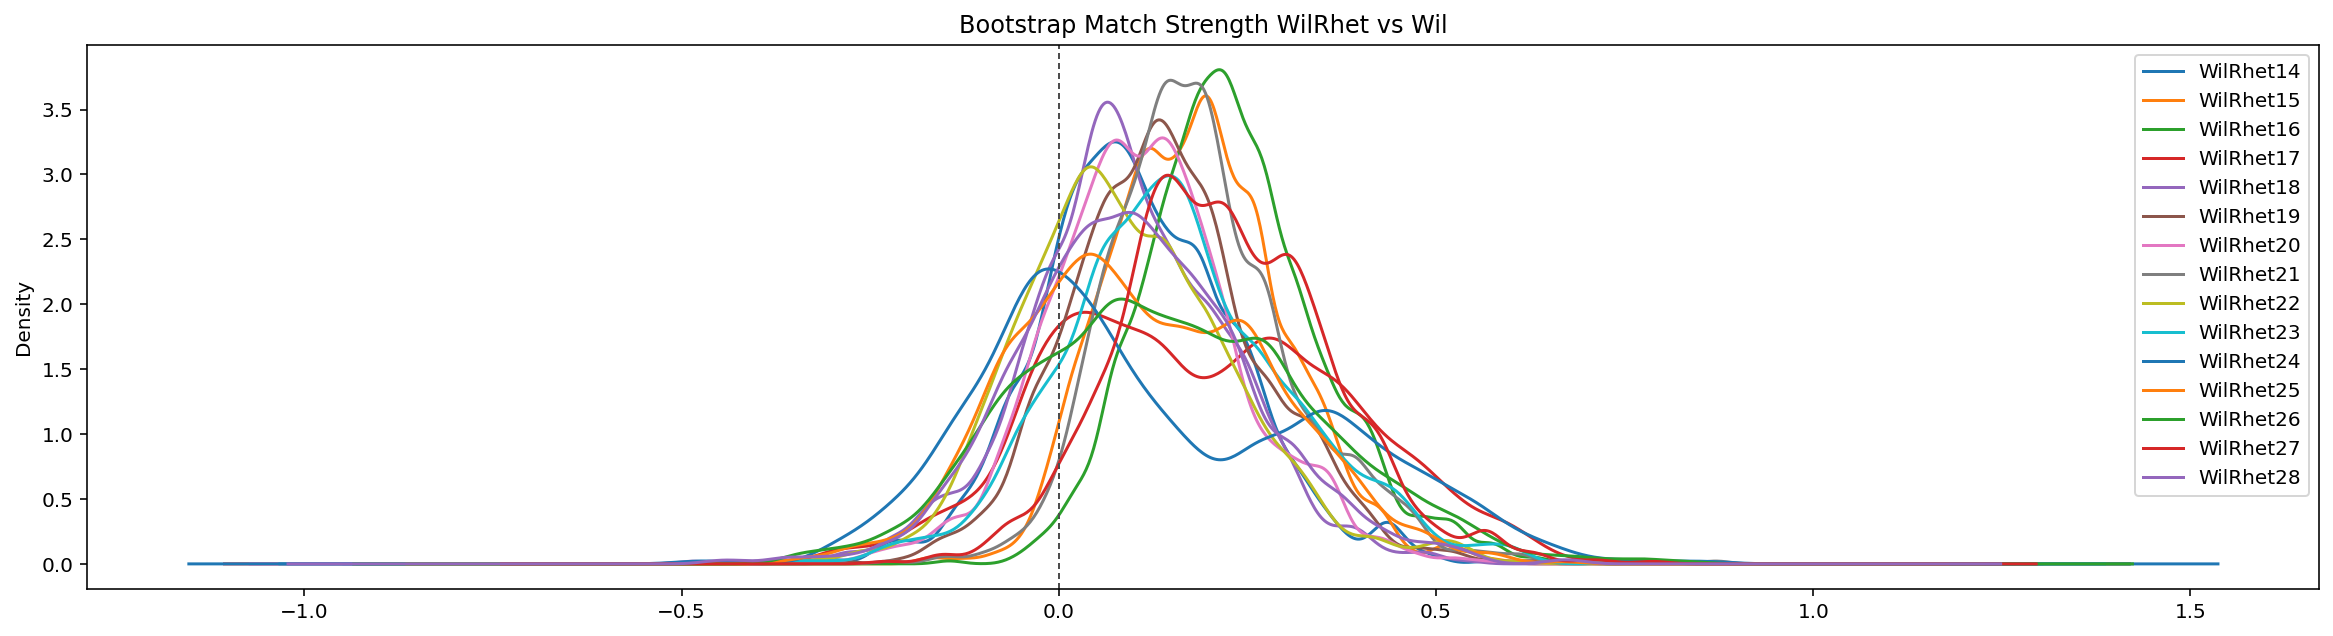

In [357]:
ax = wil_df[wil_df.columns[wil_df.columns.str.startswith("Wil")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(20, 5),
    title="Bootstrap Match Strength WilRhet vs Wil",
)
ax.axvline(0, color=".3", dashes=(3, 2), linewidth=1)

In [358]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Bxx"):
        continue
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Bar"])[0],  # type: ignore
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    results[work] = bs

bxx_df = pd.DataFrame(results)

In [359]:
s = "Bxx"
for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(bxx_df[c], 0):5.2f}  {sp.stats.skew(bxx_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.mean(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

BxxRhet0         1.70  -0.57
BxxRhet1         1.90   0.01
BxxRhet2         2.10  -0.29
BxxRhet3        29.30   0.09
BxxRhet4         1.20  -0.29
BxxRhet5         3.60  -0.46
BxxRhet6         2.60  -0.06
BxxRhet7         1.60  -0.27
BxxRhet8         3.90  -0.32
BxxRhet9         2.00  -0.38
BxxRhet10        2.10  -0.19
BxxRhet11        3.00  -0.53
BxxRhet12       22.30   0.27
BxxRhet13        3.30  -0.18

Match % -- Mean:  5.76 Std:  8.32
Skew    -- Mean: -0.23 Std:  0.23


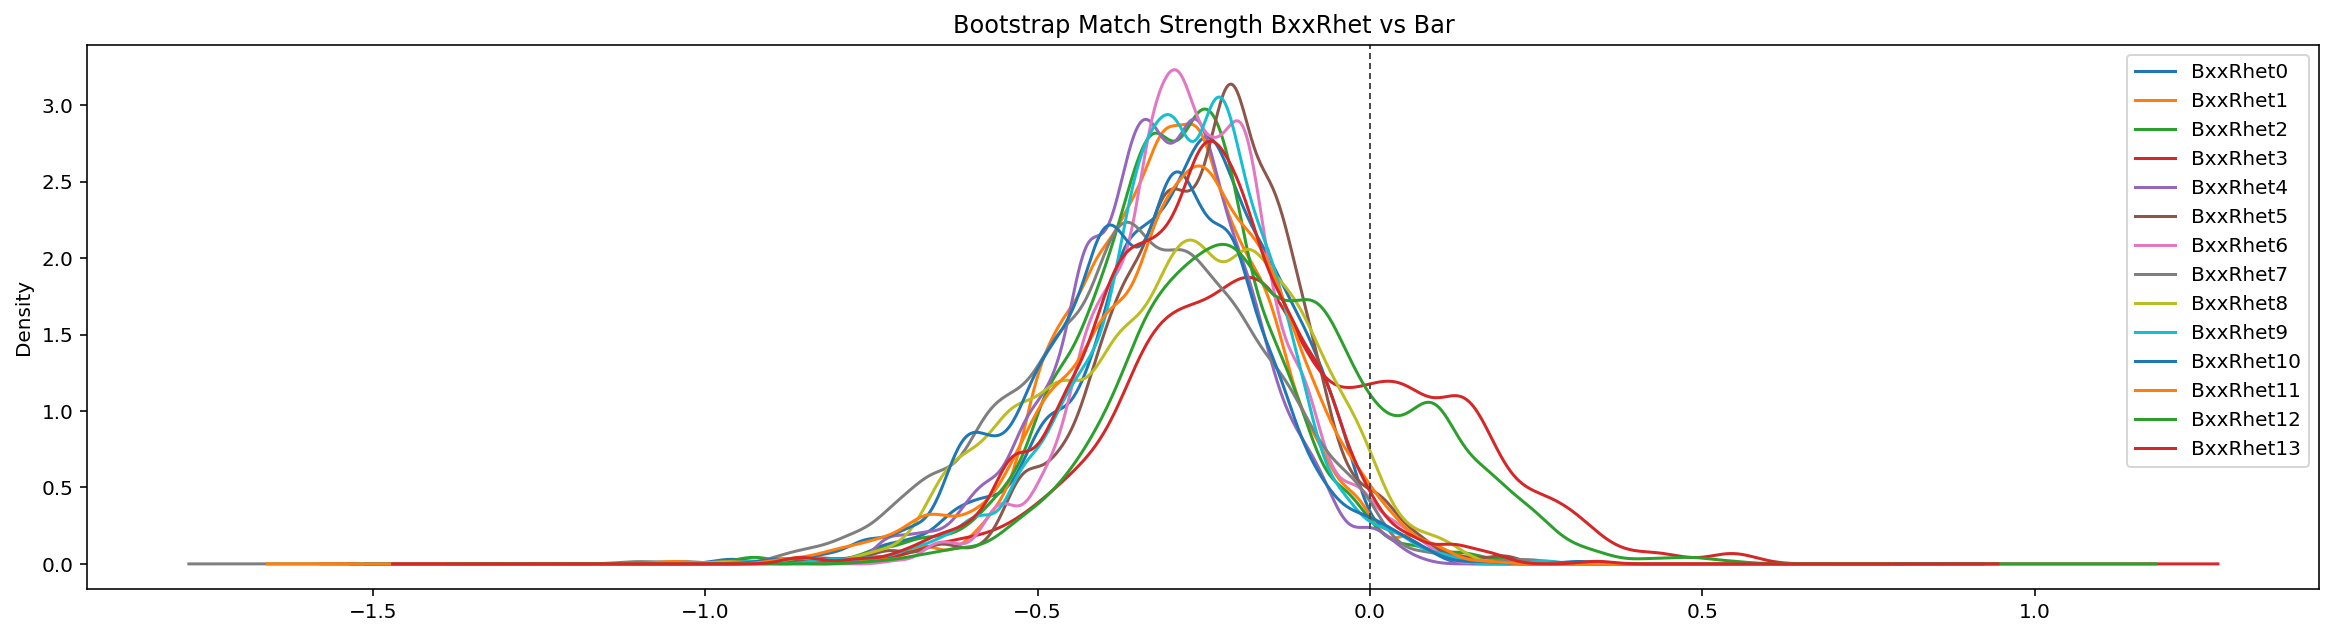

In [360]:
ax = bxx_df[bxx_df.columns[bxx_df.columns.str.startswith("Bxx")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(20, 5),
    title="Bootstrap Match Strength BxxRhet vs Bar",
)
ax.axvline(0, color=".3", dashes=(3, 2), linewidth=1)

In [562]:
df = bxx_df.melt()

In [563]:
df

,variable,value
0,BxxRhet0,-0.734767
1,BxxRhet0,-0.194054
2,BxxRhet0,-0.544061
3,BxxRhet0,-0.357411
4,BxxRhet0,-0.382929
...,...,...
13995,BxxRhet13,-0.141037
13996,BxxRhet13,-0.771016
13997,BxxRhet13,-0.038095
13998,BxxRhet13,-0.353479


In addition: Warning message:
Ignoring unknown parameters: quantile_lines, quantiles 


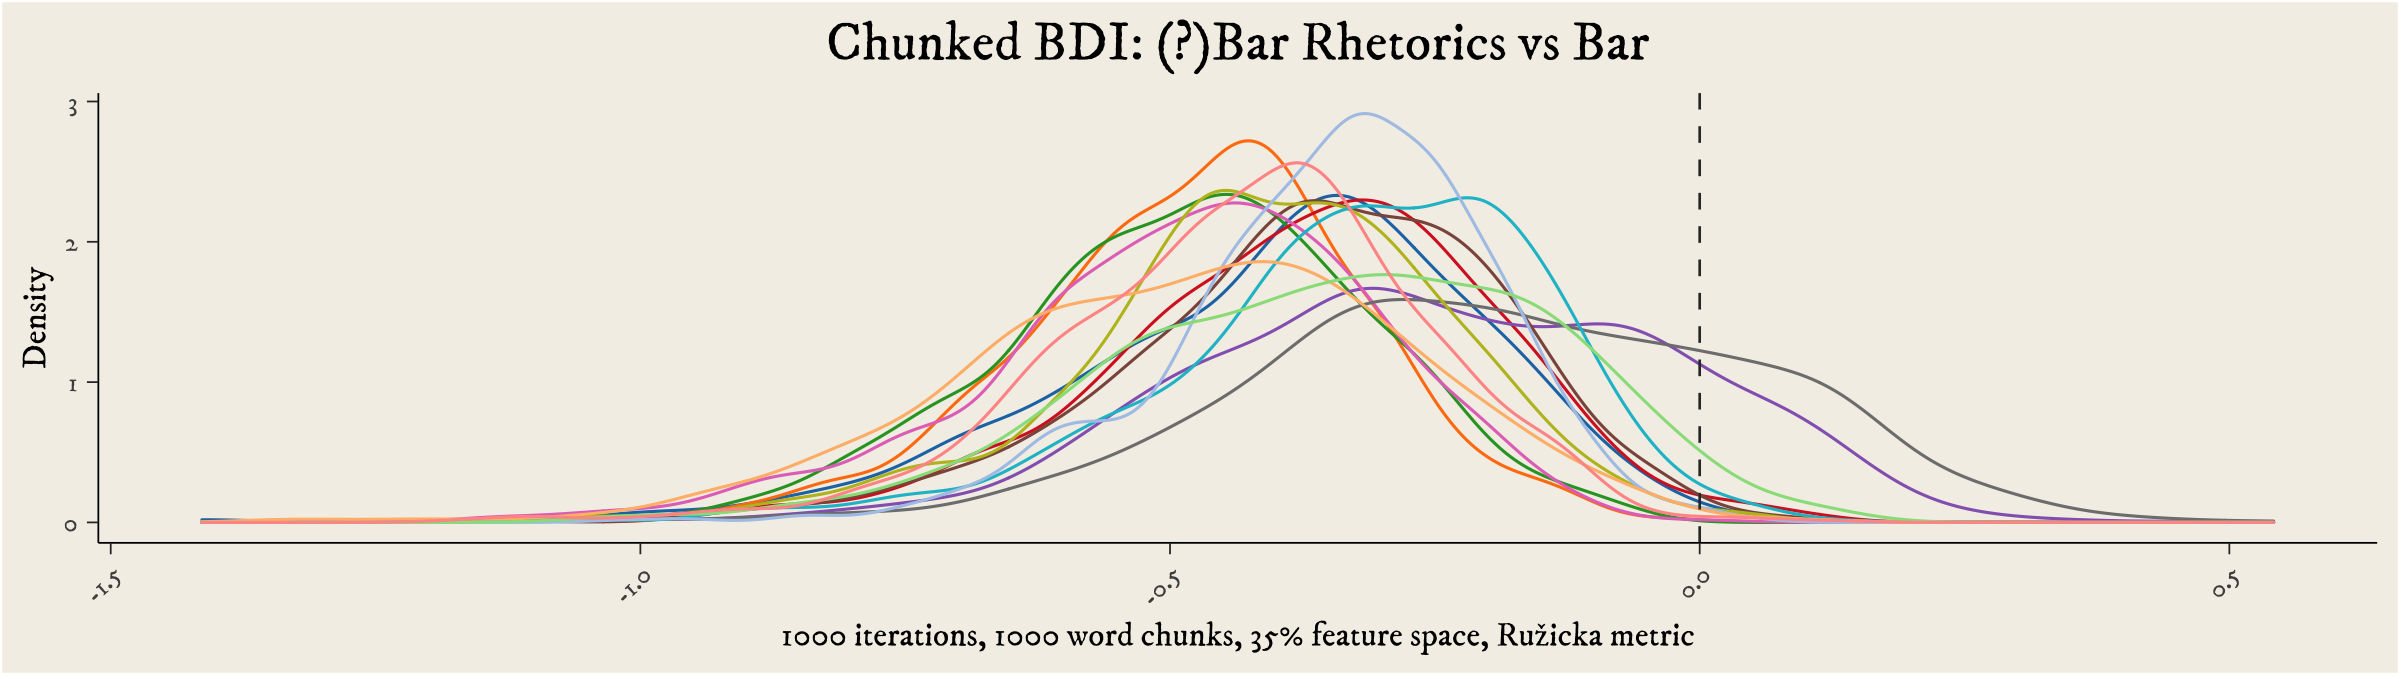

In [591]:
%%R -i df -h 2.25 -w 8 -u in -r 300

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
library(stringr)
library(dplyr)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()


plt <- "ggsci::category20_d3"
bgcol = '#f4f0e8' # antique paper

ggplot(df, aes(value, color=variable)) +
coord_cartesian(clip = "off") +
geom_density(
    quantile_lines = TRUE, quantiles = 2, size = 0.35, alpha=0.75
) +

scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
#scale_x_continuous(breaks=c(0,25,50,75,100)) +
geom_vline(xintercept=0, size=0.3, color='grey20', linetype='dashed') +
theme_bw() +
xlab("1000 iterations, 1000 word chunks, 35% feature space, Ružicka metric") +
ylab("Density") +
ggtitle("Chunked BDI: (?)Bar Rhetorics vs Bar") +
theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="fnt"),
    axis.text.x=element_text(angle = 45, hjust = 1),

)

In [575]:
wil_long = wil_df.melt()

In addition: Warning message:
Ignoring unknown parameters: quantile_lines, quantiles 


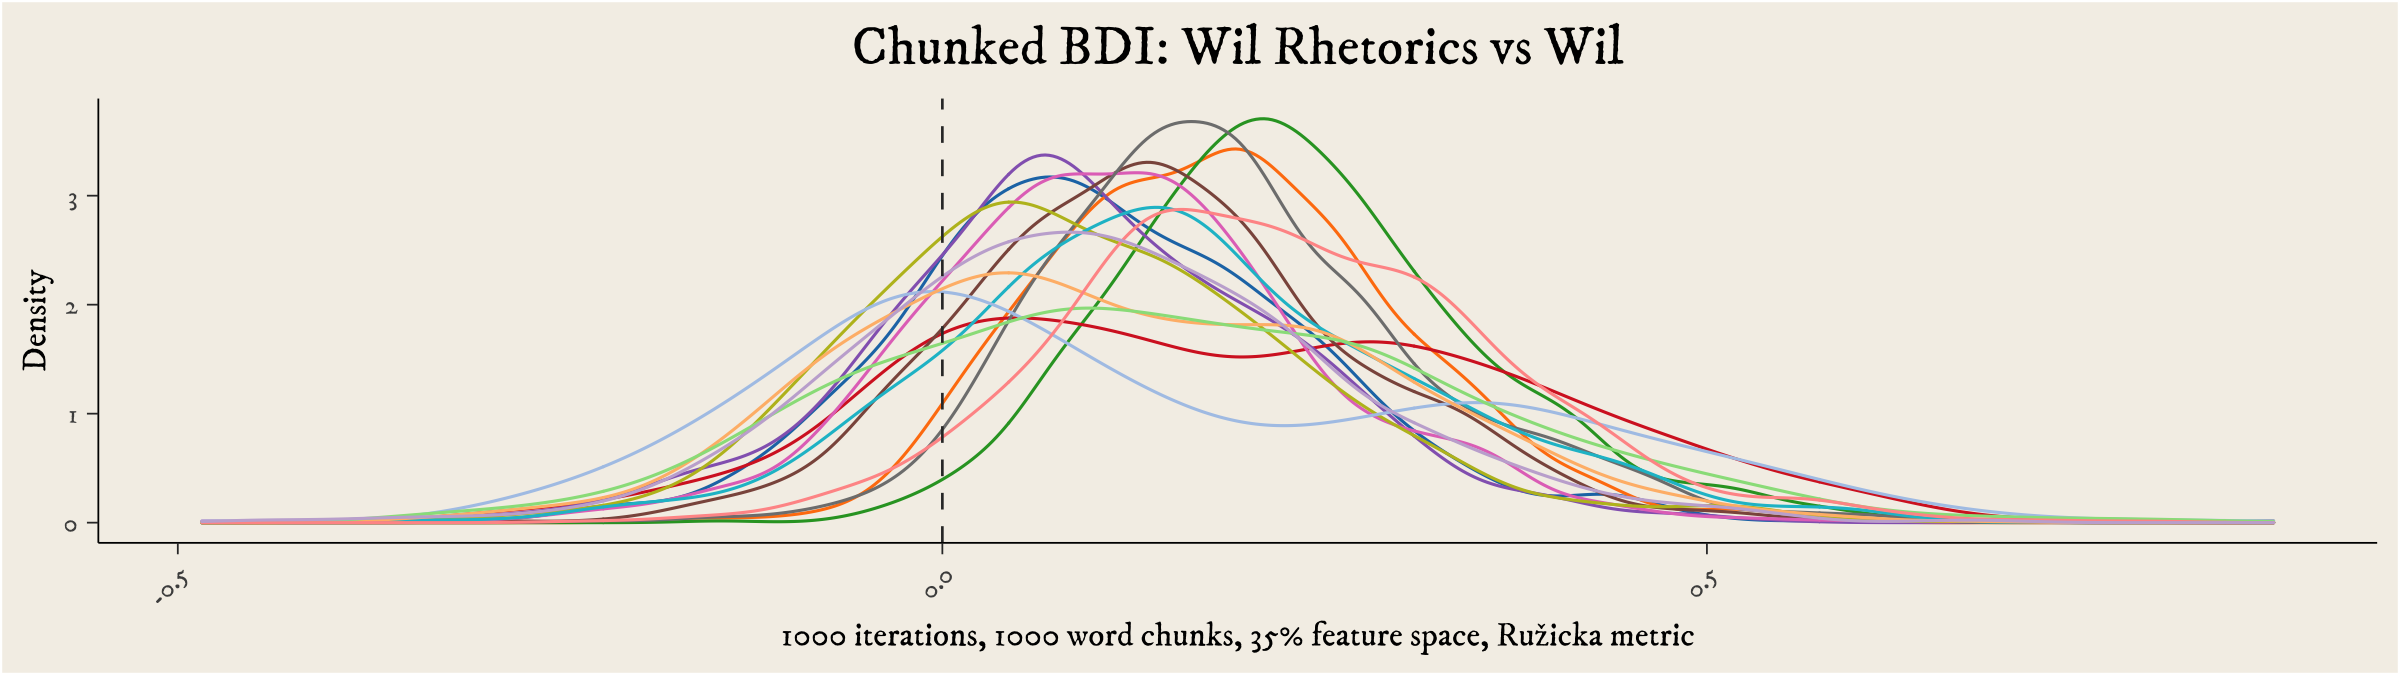

In [592]:
%%R -i wil_long -h 2.25 -w 8 -u in -r 300

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
library(stringr)
library(dplyr)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

df <- wil_long
plt <- "ggsci::category20_d3"
bgcol = '#f4f0e8' # antique paper

ggplot(df, aes(value, color=variable)) +
coord_cartesian(clip = "off") +
geom_density(
    quantile_lines = TRUE, quantiles = 2, size = 0.35, alpha=0.75
) +

scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
#scale_x_continuous(breaks=c(0,25,50,75,100)) +
geom_vline(xintercept=0, size=0.3, color='grey20', linetype='dashed') +
theme_bw() +
xlab("1000 iterations, 1000 word chunks, 35% feature space, Ružicka metric") +
ylab("Density") +
ggtitle(expression("Chunked BDI: Wil Rhetorics vs Wil")) +
theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="fnt"),
    axis.text.x=element_text(angle = 45, hjust = 1),

)

In [104]:
np.delete(
    y, np.where((comparison.Translator == "Bar") & (comparison.Work == "Mun")), 0
).shape

(1148,)

In [102]:
comparison.iloc[np.where((comparison.Translator != "Bar") | (comparison.Work != "Mun"))]

,Translator,Chunk,Work,Match,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com,7.5,0.0,0.097100,0.534050,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,sermo non quod nunquam fit in uno eodemque cor...,Com,0.4,0.0,0.200297,0.578636,0.0,0.0,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,horis anni invenire quartam coniugationem comp...,Com,2.7,0.0,0.230022,0.575055,0.0,0.0,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,quod necesse est in ea putrefieri omnia incipi...,Com,3.4,0.0,0.243044,0.710436,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,de ipsis per capitula quantum ad presentia uti...,Com,1.2,0.0,0.649435,0.409426,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,Bur,ostendat quod secundum veritatem est homo cum ...,Fid,10.5,0.0,0.024500,0.538996,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1149,Bur,causative dicere ut hoc tibi soli peccavi et p...,Fid,8.6,0.0,0.000000,0.421459,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1150,Bur,condemnavit peccatum in carne ut iustitia legi...,Fid,3.3,0.0,0.000000,0.738485,0.0,0.0,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1151,Bur,uxorem suam et concepit et genuit quare propte...,Fid,2.6,0.0,0.000000,0.666795,0.0,0.0,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [391]:
def bs_row(r):
    bs = bootstrap_imposters(
        X[r.name],
        np.delete(X, r.name, 0),
        np.delete(y, r.name),
        lenc.transform([r.Translator])[0],
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    return 100 - sp.stats.percentileofscore(bs, 0)

In [105]:
def bs_row_harsh(r):
    where = np.where(
        (comparison.Translator == r.Translator) & (comparison.Work == r.Work)
    )
    bs = bootstrap_imposters(
        X[r.name],
        np.delete(X, where, 0),
        np.delete(y, where),
        lenc.transform([r.Translator])[0],
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    return 100 - sp.stats.percentileofscore(bs, 0)

In [106]:
r = comparison.apply(bs_row_harsh, axis=1)
sp.stats.describe(r)

DescribeResult(nobs=1153, minmax=(0.20000000000000284, 99.9), mean=74.85815264527321, variance=505.4863918100125, skewness=-1.3734338751841446, kurtosis=1.3596575012592016)

In [107]:
comparison["Match"] = r
comparison

,Translator,Chunk,Work,Match,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com,64.6,0.0,0.097100,0.534050,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,sermo non quod nunquam fit in uno eodemque cor...,Com,67.6,0.0,0.200297,0.578636,0.0,0.0,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,horis anni invenire quartam coniugationem comp...,Com,73.8,0.0,0.230022,0.575055,0.0,0.0,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,quod necesse est in ea putrefieri omnia incipi...,Com,62.0,0.0,0.243044,0.710436,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,de ipsis per capitula quantum ad presentia uti...,Com,38.1,0.0,0.649435,0.409426,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,Bur,ostendat quod secundum veritatem est homo cum ...,Fid,42.1,0.0,0.024500,0.538996,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1149,Bur,causative dicere ut hoc tibi soli peccavi et p...,Fid,41.5,0.0,0.000000,0.421459,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1150,Bur,condemnavit peccatum in carne ut iustitia legi...,Fid,69.6,0.0,0.000000,0.738485,0.0,0.0,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1151,Bur,uxorem suam et concepit et genuit quare propte...,Fid,71.4,0.0,0.000000,0.666795,0.0,0.0,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [72]:
import seaborn as sns

In [108]:
compound = comparison.apply(lambda r: f"{r['Translator']}-{r['Work']}", axis=1)

In [109]:
sbdf = comparison.copy()
sbdf["CompoundWork"] = compound

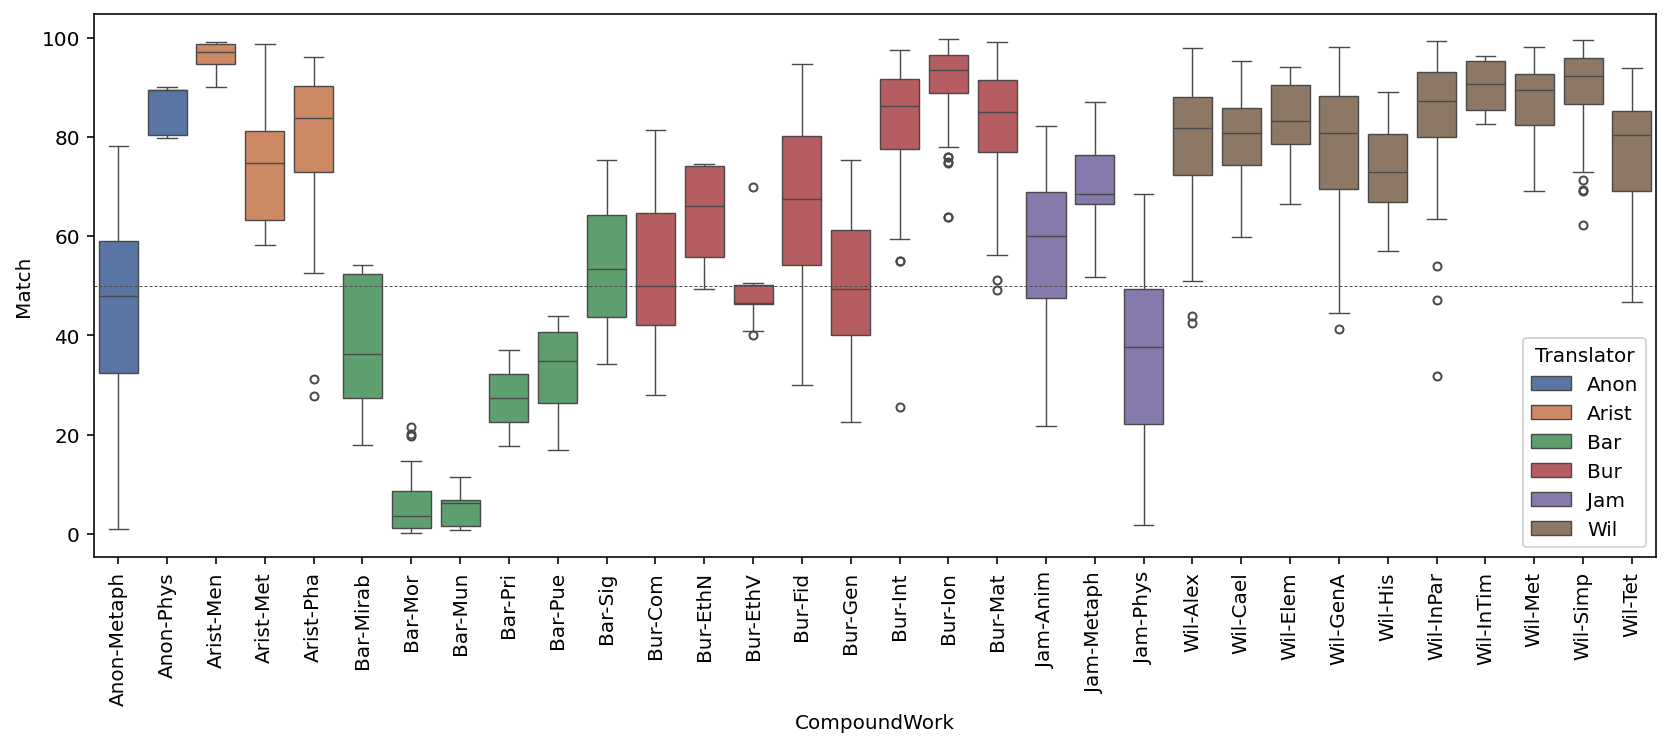

In [114]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.xticks(rotation=90)

sax = sns.boxplot(
    ax=ax,
    data=sbdf.sort_values(by="CompoundWork"),
    x="CompoundWork",
    y="Match",
    hue="Translator",
    linewidth=0.7,
    palette="deep",
    fliersize=4,
    flierprops={"marker": "o"},
)
sax.axhline(50, color=".3", dashes=(3, 2), linewidth=0.5)

In [245]:
comparison[comparison.Work == "Phys"][comparison.Translator == "Anon"]

/var/folders/wt/_hvfndq56jvd5k42nrkq9fy00000gn/T/ipykernel_20976/2936714822.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comparison[comparison.Work == "Phys"][comparison.Translator == "Anon"]


,Translator,Chunk,Work,Match,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
592,Anon,quoniam agnoscere et scire circa methodos omne...,Phys,88.9,0.0,0.701313,0.292214,0.0,0.0,0.0,...,0.038962,0.000000,0.000000,0.000000,0.214290,0.0,0.019481,0.019481,0.370138,0.0
593,Anon,deinde et hoc inconueniens omnis arbitrari ess...,Phys,68.5,0.0,0.446292,0.263718,0.0,0.0,0.0,...,0.101430,0.020286,0.000000,0.020286,0.182574,0.0,0.000000,0.000000,0.324576,0.0
594,Anon,fiunt sed secernuntur inentia dicuntur autem a...,Phys,85.1,0.0,0.298791,0.390727,0.0,0.0,0.0,...,0.022984,0.000000,0.022984,0.022984,0.298791,0.0,0.000000,0.000000,0.528631,0.0
595,Anon,entium substantiam contraria principium uero n...,Phys,96.6,0.0,0.381375,0.281013,0.0,0.0,0.0,...,0.080290,0.000000,0.000000,0.000000,0.441593,0.0,0.020072,0.000000,0.541955,0.0
596,Anon,natura scibilis secundum analogiam sicut enim ...,Phys,94.5,0.0,0.589540,0.294770,0.0,0.0,0.0,...,0.136048,0.022675,0.000000,0.022675,0.204072,0.0,0.000000,0.000000,0.430818,0.0


In [361]:
experiment = comparison[(comparison.Translator != "Bar") | (comparison.Work == "Mor")]

In [362]:
experiment

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,EthV,duplici autem virtute existente hac quidem int...,0.000000,0.062338,0.685717,0.0,0.0,0.0,0.020779,...,0.207793,0.000000,0.0,0.000000,0.207793,0.041559,0.0,0.0,0.145455,0.0
1,Bur,EthV,malicia autem contrarium fiet autem nobis et e...,0.000000,0.049793,0.813285,0.0,0.0,0.0,0.000000,...,0.165977,0.000000,0.0,0.000000,0.016598,0.066391,0.0,0.0,0.066391,0.0
2,Bur,EthV,bene habentibus operis quoniam neque auferendu...,0.000000,0.000000,0.896433,0.0,0.0,0.0,0.011493,...,0.034478,0.000000,0.0,0.000000,0.091942,0.011493,0.0,0.0,0.045971,0.0
3,Bur,EthV,et medietas amicicia qui superhabundat autem q...,0.000000,0.064567,0.774798,0.0,0.0,0.0,0.000000,...,0.096850,0.000000,0.0,0.000000,0.080708,0.064567,0.0,0.0,0.032283,0.0
4,Bur,EthV,iacit volens in salute autem sui ipsius et rel...,0.000000,0.150855,0.822845,0.0,0.0,0.0,0.054856,...,0.013714,0.000000,0.0,0.000000,0.095999,0.123427,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,Anon,Metaph,palam nec enim impar infinitus est nec par gen...,0.025294,0.328824,0.227648,0.0,0.0,0.0,0.000000,...,0.126471,0.075883,0.0,0.075883,0.430001,0.000000,0.0,0.0,0.455295,0.0
1153,Anon,Metaph,aut non quare eadem accident et sic aut enim n...,0.000000,0.298142,0.238514,0.0,0.0,0.0,0.059628,...,0.089443,0.000000,0.0,0.000000,0.268328,0.000000,0.0,0.0,0.566471,0.0
1154,Anon,Metaph,quidem potentia illud vero actu ergo potentia ...,0.000000,0.380143,0.253429,0.0,0.0,0.0,0.050686,...,0.050686,0.000000,0.0,0.025343,0.456172,0.000000,0.0,0.0,0.481514,0.0
1155,Anon,Metaph,tempori non finis est non etiam erit sempitern...,0.030331,0.242647,0.242647,0.0,0.0,0.0,0.060662,...,0.060662,0.060662,0.0,0.000000,0.121324,0.000000,0.0,0.0,0.454963,0.0


In [363]:
experiment_X = ss.transform(experiment[feat_cols])
experiment_y = np.array(lenc.transform(experiment.Translator))

In [365]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Bxx"):
        continue
    bs = bootstrap_imposters(
        vec,
        experiment_X,
        experiment_y,
        lenc.transform(["Bar"])[0],  # type: ignore
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    results[work] = bs

bxx_df = pd.DataFrame(results)

In [366]:
s = "Bxx"
for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(bxx_df[c], 0):5.2f}  {sp.stats.skew(bxx_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.mean(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

BxxRhet0         0.60  -0.83
BxxRhet1         0.00  -0.40
BxxRhet2         0.10  -0.57
BxxRhet3        24.30  -0.19
BxxRhet4         0.60  -0.58
BxxRhet5         1.40  -0.97
BxxRhet6         0.30  -0.65
BxxRhet7         0.30  -0.39
BxxRhet8         3.10  -0.36
BxxRhet9         0.40  -0.53
BxxRhet10        0.00  -0.24
BxxRhet11        1.50  -0.53
BxxRhet12       15.10  -0.22
BxxRhet13        0.60  -0.55

Match % -- Mean:  3.45 Std:  6.90
Skew    -- Mean: -0.50 Std:  0.22


In [116]:
problems

,Translator,Chunk,Work,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bxx,BxxRhet0,Rhet,0.0,0.394042,0.497737,0.000000,0.0,0.000000,0.020739,...,0.062217,0.041478,0.0,0.020739,0.165912,0.228129,0.000000,0.0,0.331825,0.0
1,Bxx,BxxRhet1,Rhet,0.0,0.277810,0.590345,0.000000,0.0,0.000000,0.052089,...,0.052089,0.156268,0.0,0.034726,0.121542,0.069452,0.000000,0.0,0.347262,0.0
2,Bxx,BxxRhet2,Rhet,0.0,0.267038,0.534076,0.000000,0.0,0.000000,0.066759,...,0.050070,0.233658,0.0,0.000000,0.183588,0.066759,0.000000,0.0,0.317107,0.0
3,Bxx,BxxRhet3,Rhet,0.0,0.524604,0.671493,0.000000,0.0,0.000000,0.000000,...,0.020984,0.041968,0.0,0.020984,0.104921,0.125905,0.000000,0.0,0.104921,0.0
4,Bxx,BxxRhet4,Rhet,0.0,0.636098,0.371057,0.000000,0.0,0.000000,0.070678,...,0.070678,0.035339,0.0,0.000000,0.088347,0.141355,0.000000,0.0,0.512412,0.0
5,Bxx,BxxRhet5,Rhet,0.0,0.501868,0.259587,0.000000,0.0,0.000000,0.017306,...,0.017306,0.173058,0.0,0.000000,0.173058,0.190364,0.000000,0.0,0.380728,0.0
6,Bxx,BxxRhet6,Rhet,0.0,0.446895,0.169512,0.015410,0.0,0.000000,0.015410,...,0.030820,0.092461,0.0,0.046231,0.123281,0.154102,0.000000,0.0,0.385254,0.0
7,Bxx,BxxRhet7,Rhet,0.0,0.279386,0.558772,0.000000,0.0,0.000000,0.059868,...,0.039912,0.099781,0.0,0.019956,0.079825,0.079825,0.000000,0.0,0.439035,0.0
8,Bxx,BxxRhet8,Rhet,0.0,0.305869,0.415108,0.000000,0.0,0.000000,0.021848,...,0.043696,0.152935,0.0,0.043696,0.218478,0.174783,0.000000,0.0,0.196630,0.0
9,Bxx,BxxRhet9,Rhet,0.0,0.480519,0.294512,0.015501,0.0,0.000000,0.015501,...,0.000000,0.015501,0.0,0.046502,0.062002,0.108504,0.000000,0.0,0.558022,0.0


In [367]:
bar_rhet = stops_tidy[
    (stops_tidy.Work == "Rhet") & (stops_tidy.Translator == "Bxx")
].copy()
bar_rhet["Translator"] = "Bar"

In [368]:
bar_rhet

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
658,Bar,Rhet,rethorica est convertibilis dialetice utreque ...,0.0,0.394042,0.497737,0.000000,0.0,0.0,0.020739,...,0.062217,0.041478,0.0,0.020739,0.165912,0.228129,0.0,0.0,0.331825,0.0
659,Bar,Rhet,iuverit maxime utens iuste et leserit iniuste ...,0.0,0.277810,0.590345,0.000000,0.0,0.0,0.052089,...,0.052089,0.156268,0.0,0.034726,0.121542,0.069452,0.0,0.0,0.347262,0.0
660,Bar,Rhet,horum cognitum non oportet dicere ipse enim au...,0.0,0.267038,0.534076,0.000000,0.0,0.0,0.066759,...,0.050070,0.233658,0.0,0.000000,0.183588,0.066759,0.0,0.0,0.317107,0.0
661,Bar,Rhet,quomodo non lesit quoniam autem iniustificat n...,0.0,0.524604,0.671493,0.000000,0.0,0.0,0.000000,...,0.020984,0.041968,0.0,0.020984,0.104921,0.125905,0.0,0.0,0.104921,0.0
662,Bar,Rhet,sunt ex quibus autem oportet et de hiis et ali...,0.0,0.636098,0.371057,0.000000,0.0,0.0,0.070678,...,0.070678,0.035339,0.0,0.000000,0.088347,0.141355,0.0,0.0,0.512412,0.0
663,Bar,Rhet,ut puta quorum natura contingit vero et extra ...,0.0,0.501868,0.259587,0.000000,0.0,0.0,0.017306,...,0.017306,0.173058,0.0,0.000000,0.173058,0.190364,0.0,0.0,0.380728,0.0
664,Bar,Rhet,quidem semper et plus ad minus magnum autem et...,0.0,0.446895,0.169512,0.015410,0.0,0.0,0.015410,...,0.030820,0.092461,0.0,0.046231,0.123281,0.154102,0.0,0.0,0.385254,0.0
665,Bar,Rhet,dicit meleagrum persuaderi ab uxore dicente qu...,0.0,0.279386,0.558772,0.000000,0.0,0.0,0.059868,...,0.039912,0.099781,0.0,0.019956,0.079825,0.079825,0.0,0.0,0.439035,0.0
666,Bar,Rhet,de universali et de partibus dictum est secund...,0.0,0.305869,0.415108,0.000000,0.0,0.0,0.021848,...,0.043696,0.152935,0.0,0.043696,0.218478,0.174783,0.0,0.0,0.196630,0.0
667,Bar,Rhet,enim ex contrariis est de accusatione vero et ...,0.0,0.480519,0.294512,0.015501,0.0,0.0,0.015501,...,0.000000,0.015501,0.0,0.046502,0.062002,0.108504,0.0,0.0,0.558022,0.0


In [369]:
wil_rhet = stops_tidy[
    (stops_tidy.Work == "Rhet") & (stops_tidy.Translator == "Wil")
].copy()

In [370]:
wil_rhet

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
1028,Wil,Rhet,rethorica assecutiva dialetice est ambe enim d...,0.0,0.319732,0.601848,0.0,0.0,0.000000,0.000000,...,0.037616,0.112847,0.0,0.000000,0.150462,0.150462,0.000000,0.0,0.018808,0.0
1029,Wil,Rhet,et eos qui non possunt recipere sanitatem tame...,0.0,0.207550,0.756074,0.0,0.0,0.014825,0.029650,...,0.044475,0.088950,0.0,0.014825,0.103775,0.000000,0.029650,0.0,0.029650,0.0
1030,Wil,Rhet,sunt pauca quidem necessaria ex quibus rethori...,0.0,0.131647,0.750390,0.0,0.0,0.000000,0.026329,...,0.039494,0.026329,0.0,0.039494,0.236965,0.039494,0.039494,0.0,0.026329,0.0
1031,Wil,Rhet,puta qui diiudicatur quomodo non fuerit factum...,0.0,0.410564,0.759544,0.0,0.0,0.000000,0.020528,...,0.000000,0.020528,0.0,0.000000,0.102641,0.143697,0.000000,0.0,0.000000,0.0
1032,Wil,Rhet,quare palam quod ad legislationem quidem terre...,0.0,0.448704,0.769207,0.0,0.0,0.000000,0.112176,...,0.048075,0.032050,0.0,0.000000,0.096151,0.048075,0.000000,0.0,0.016025,0.0
1033,Wil,Rhet,utique bene fortunatus permanebit est autem qu...,0.0,0.277868,0.719189,0.0,0.0,0.000000,0.000000,...,0.016345,0.016345,0.0,0.016345,0.196142,0.065381,0.032690,0.0,0.016345,0.0
1034,Wil,Rhet,omnes aut multi aut similes aut que minores di...,0.0,0.386769,0.520651,0.0,0.0,0.000000,0.000000,...,0.014876,0.014876,0.0,0.000000,0.089254,0.089254,0.000000,0.0,0.014876,0.0
1035,Wil,Rhet,voluntate cum enim velint existit magis qui fi...,0.0,0.216179,0.602213,0.0,0.0,0.000000,0.061765,...,0.015441,0.000000,0.0,0.000000,0.046324,0.108090,0.030883,0.0,0.015441,0.0
1036,Wil,Rhet,virtutis iustitia et fortitudo temperantia mag...,0.0,0.168852,0.731693,0.0,0.0,0.000000,0.056284,...,0.056284,0.037523,0.0,0.056284,0.093807,0.093807,0.018761,0.0,0.000000,0.0
1037,Wil,Rhet,prohibens hoc autem non prohibens transponatur...,0.0,0.291256,0.823115,0.0,0.0,0.000000,0.050653,...,0.000000,0.000000,0.0,0.000000,0.063317,0.050653,0.000000,0.0,0.025327,0.0


In [371]:
full_disaster = pd.concat([comparison, bar_rhet, wil_rhet]).reset_index(drop=True)

In [372]:
full_disaster[full_disaster.Work == "Rhet"]

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
1157,Bar,Rhet,rethorica est convertibilis dialetice utreque ...,0.0,0.394042,0.497737,0.000000,0.0,0.000000,0.020739,...,0.062217,0.041478,0.0,0.020739,0.165912,0.228129,0.000000,0.0,0.331825,0.0
1158,Bar,Rhet,iuverit maxime utens iuste et leserit iniuste ...,0.0,0.277810,0.590345,0.000000,0.0,0.000000,0.052089,...,0.052089,0.156268,0.0,0.034726,0.121542,0.069452,0.000000,0.0,0.347262,0.0
1159,Bar,Rhet,horum cognitum non oportet dicere ipse enim au...,0.0,0.267038,0.534076,0.000000,0.0,0.000000,0.066759,...,0.050070,0.233658,0.0,0.000000,0.183588,0.066759,0.000000,0.0,0.317107,0.0
1160,Bar,Rhet,quomodo non lesit quoniam autem iniustificat n...,0.0,0.524604,0.671493,0.000000,0.0,0.000000,0.000000,...,0.020984,0.041968,0.0,0.020984,0.104921,0.125905,0.000000,0.0,0.104921,0.0
1161,Bar,Rhet,sunt ex quibus autem oportet et de hiis et ali...,0.0,0.636098,0.371057,0.000000,0.0,0.000000,0.070678,...,0.070678,0.035339,0.0,0.000000,0.088347,0.141355,0.000000,0.0,0.512412,0.0
1162,Bar,Rhet,ut puta quorum natura contingit vero et extra ...,0.0,0.501868,0.259587,0.000000,0.0,0.000000,0.017306,...,0.017306,0.173058,0.0,0.000000,0.173058,0.190364,0.000000,0.0,0.380728,0.0
1163,Bar,Rhet,quidem semper et plus ad minus magnum autem et...,0.0,0.446895,0.169512,0.015410,0.0,0.000000,0.015410,...,0.030820,0.092461,0.0,0.046231,0.123281,0.154102,0.000000,0.0,0.385254,0.0
1164,Bar,Rhet,dicit meleagrum persuaderi ab uxore dicente qu...,0.0,0.279386,0.558772,0.000000,0.0,0.000000,0.059868,...,0.039912,0.099781,0.0,0.019956,0.079825,0.079825,0.000000,0.0,0.439035,0.0
1165,Bar,Rhet,de universali et de partibus dictum est secund...,0.0,0.305869,0.415108,0.000000,0.0,0.000000,0.021848,...,0.043696,0.152935,0.0,0.043696,0.218478,0.174783,0.000000,0.0,0.196630,0.0
1166,Bar,Rhet,enim ex contrariis est de accusatione vero et ...,0.0,0.480519,0.294512,0.015501,0.0,0.000000,0.015501,...,0.000000,0.015501,0.0,0.046502,0.062002,0.108504,0.000000,0.0,0.558022,0.0


In [373]:
ss = StandardScaler(with_mean=False).fit(full_disaster[feat_cols])
lenc = LabelEncoder()
labels = lenc.fit_transform(full_disaster.Translator)

In [374]:
X = ss.transform(full_disaster[feat_cols])
y = np.array(lenc.transform(full_disaster.Translator))

In [494]:
def bs_row_harsh(r, df, X, y):
    where = np.where((df.Translator == r.Translator) & (df.Work == r.Work))
    bs = bootstrap_imposters(
        X[r.name],
        np.delete(X, where, 0),
        np.delete(y, where),
        lenc.transform([r.Translator])[0],
        1000,
        0.5,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    return 100 - sp.stats.percentileofscore(bs, 0)

In [ ]:
def bs_row(r, X, y):
    bs = bootstrap_imposters(
        X[r.name],
        np.delete(X, r.name, 0),
        np.delete(y, r.name),
        lenc.transform([r.Translator])[0],
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    return 100 - sp.stats.percentileofscore(bs, 0)

In [376]:
r = full_disaster.apply(lambda row: bs_row_harsh(row, X, y), axis=1)
sp.stats.describe(r)

DescribeResult(nobs=1186, minmax=(0.7999999999999972, 99.9), mean=73.61741146711636, variance=567.4207535470077, skewness=-1.3304991219079754, kurtosis=1.0531897553473213)

In [392]:
reasy = full_disaster.apply(lambda row: bs_row(row, X, y), axis=1)
sp.stats.describe(reasy)

DescribeResult(nobs=1186, minmax=(4.799999999999997, 100.0), mean=87.51918212478921, variance=243.41288279043127, skewness=-2.100174643612222, kurtosis=4.718007287631321)

In [377]:
full_disaster["Match"] = r
full_disaster

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet,Match
0,Bur,EthV,duplici autem virtute existente hac quidem int...,0.0,0.062338,0.685717,0.0,0.0,0.0,0.020779,...,0.000000,0.0,0.000000,0.207793,0.041559,0.000000,0.0,0.145455,0.0,46.2
1,Bur,EthV,malicia autem contrarium fiet autem nobis et e...,0.0,0.049793,0.813285,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.016598,0.066391,0.000000,0.0,0.066391,0.0,45.3
2,Bur,EthV,bene habentibus operis quoniam neque auferendu...,0.0,0.000000,0.896433,0.0,0.0,0.0,0.011493,...,0.000000,0.0,0.000000,0.091942,0.011493,0.000000,0.0,0.045971,0.0,35.5
3,Bur,EthV,et medietas amicicia qui superhabundat autem q...,0.0,0.064567,0.774798,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.080708,0.064567,0.000000,0.0,0.032283,0.0,49.0
4,Bur,EthV,iacit volens in salute autem sui ipsius et rel...,0.0,0.150855,0.822845,0.0,0.0,0.0,0.054856,...,0.000000,0.0,0.000000,0.095999,0.123427,0.000000,0.0,0.000000,0.0,49.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,Wil,Rhet,consuetum inter delectabilia multa enim et eor...,0.0,0.389887,0.576354,0.0,0.0,0.0,0.135613,...,0.050855,0.0,0.000000,0.101710,0.050855,0.016952,0.0,0.016952,0.0,64.5
1182,Wil,Rhet,excessum facit constituti habitus unde dictum ...,0.0,0.570579,0.535999,0.0,0.0,0.0,0.051871,...,0.086451,0.0,0.017290,0.155612,0.155612,0.051871,0.0,0.017290,0.0,68.9
1183,Wil,Rhet,omnes latere et in desides solliciti enim est ...,0.0,0.718926,0.453236,0.0,0.0,0.0,0.031258,...,0.046886,0.0,0.078144,0.187546,0.046886,0.031258,0.0,0.000000,0.0,70.1
1184,Wil,Rhet,secundum excessum virtutis et malitie in quibu...,0.0,0.136134,0.563985,0.0,0.0,0.0,0.058343,...,0.019448,0.0,0.019448,0.097239,0.058343,0.058343,0.0,0.019448,0.0,95.2


In [393]:
full_disaster["MatchEasy"] = reasy
full_disaster

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet,Match,MatchEasy
0,Bur,EthV,duplici autem virtute existente hac quidem int...,0.0,0.062338,0.685717,0.0,0.0,0.0,0.020779,...,0.0,0.000000,0.207793,0.041559,0.000000,0.0,0.145455,0.0,46.2,52.0
1,Bur,EthV,malicia autem contrarium fiet autem nobis et e...,0.0,0.049793,0.813285,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.016598,0.066391,0.000000,0.0,0.066391,0.0,45.3,70.7
2,Bur,EthV,bene habentibus operis quoniam neque auferendu...,0.0,0.000000,0.896433,0.0,0.0,0.0,0.011493,...,0.0,0.000000,0.091942,0.011493,0.000000,0.0,0.045971,0.0,35.5,42.1
3,Bur,EthV,et medietas amicicia qui superhabundat autem q...,0.0,0.064567,0.774798,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.080708,0.064567,0.000000,0.0,0.032283,0.0,49.0,71.5
4,Bur,EthV,iacit volens in salute autem sui ipsius et rel...,0.0,0.150855,0.822845,0.0,0.0,0.0,0.054856,...,0.0,0.000000,0.095999,0.123427,0.000000,0.0,0.000000,0.0,49.3,55.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,Wil,Rhet,consuetum inter delectabilia multa enim et eor...,0.0,0.389887,0.576354,0.0,0.0,0.0,0.135613,...,0.0,0.000000,0.101710,0.050855,0.016952,0.0,0.016952,0.0,64.5,72.0
1182,Wil,Rhet,excessum facit constituti habitus unde dictum ...,0.0,0.570579,0.535999,0.0,0.0,0.0,0.051871,...,0.0,0.017290,0.155612,0.155612,0.051871,0.0,0.017290,0.0,68.9,77.1
1183,Wil,Rhet,omnes latere et in desides solliciti enim est ...,0.0,0.718926,0.453236,0.0,0.0,0.0,0.031258,...,0.0,0.078144,0.187546,0.046886,0.031258,0.0,0.000000,0.0,70.1,79.3
1184,Wil,Rhet,secundum excessum virtutis et malitie in quibu...,0.0,0.136134,0.563985,0.0,0.0,0.0,0.058343,...,0.0,0.019448,0.097239,0.058343,0.058343,0.0,0.019448,0.0,95.2,96.9


In [378]:
import seaborn as sns

In [379]:
compound = full_disaster.apply(lambda r: f"{r['Translator']}-{r['Work']}", axis=1)

In [394]:
sbdf = full_disaster.copy()
sbdf["CompoundWork"] = compound

In [404]:
sbdf

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,tamquam,ut,utique,uelut,ueluti,uero,uidelicet,Match,MatchEasy,CompoundWork
0,Bur,EthV,duplici autem virtute existente hac quidem int...,0.0,0.062338,0.685717,0.0,0.0,0.0,0.020779,...,0.000000,0.207793,0.041559,0.000000,0.0,0.145455,0.0,46.2,52.0,Bur-EthV
1,Bur,EthV,malicia autem contrarium fiet autem nobis et e...,0.0,0.049793,0.813285,0.0,0.0,0.0,0.000000,...,0.000000,0.016598,0.066391,0.000000,0.0,0.066391,0.0,45.3,70.7,Bur-EthV
2,Bur,EthV,bene habentibus operis quoniam neque auferendu...,0.0,0.000000,0.896433,0.0,0.0,0.0,0.011493,...,0.000000,0.091942,0.011493,0.000000,0.0,0.045971,0.0,35.5,42.1,Bur-EthV
3,Bur,EthV,et medietas amicicia qui superhabundat autem q...,0.0,0.064567,0.774798,0.0,0.0,0.0,0.000000,...,0.000000,0.080708,0.064567,0.000000,0.0,0.032283,0.0,49.0,71.5,Bur-EthV
4,Bur,EthV,iacit volens in salute autem sui ipsius et rel...,0.0,0.150855,0.822845,0.0,0.0,0.0,0.054856,...,0.000000,0.095999,0.123427,0.000000,0.0,0.000000,0.0,49.3,55.1,Bur-EthV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,Wil,Rhet,consuetum inter delectabilia multa enim et eor...,0.0,0.389887,0.576354,0.0,0.0,0.0,0.135613,...,0.000000,0.101710,0.050855,0.016952,0.0,0.016952,0.0,64.5,72.0,Wil-Rhet
1182,Wil,Rhet,excessum facit constituti habitus unde dictum ...,0.0,0.570579,0.535999,0.0,0.0,0.0,0.051871,...,0.017290,0.155612,0.155612,0.051871,0.0,0.017290,0.0,68.9,77.1,Wil-Rhet
1183,Wil,Rhet,omnes latere et in desides solliciti enim est ...,0.0,0.718926,0.453236,0.0,0.0,0.0,0.031258,...,0.078144,0.187546,0.046886,0.031258,0.0,0.000000,0.0,70.1,79.3,Wil-Rhet
1184,Wil,Rhet,secundum excessum virtutis et malitie in quibu...,0.0,0.136134,0.563985,0.0,0.0,0.0,0.058343,...,0.019448,0.097239,0.058343,0.058343,0.0,0.019448,0.0,95.2,96.9,Wil-Rhet


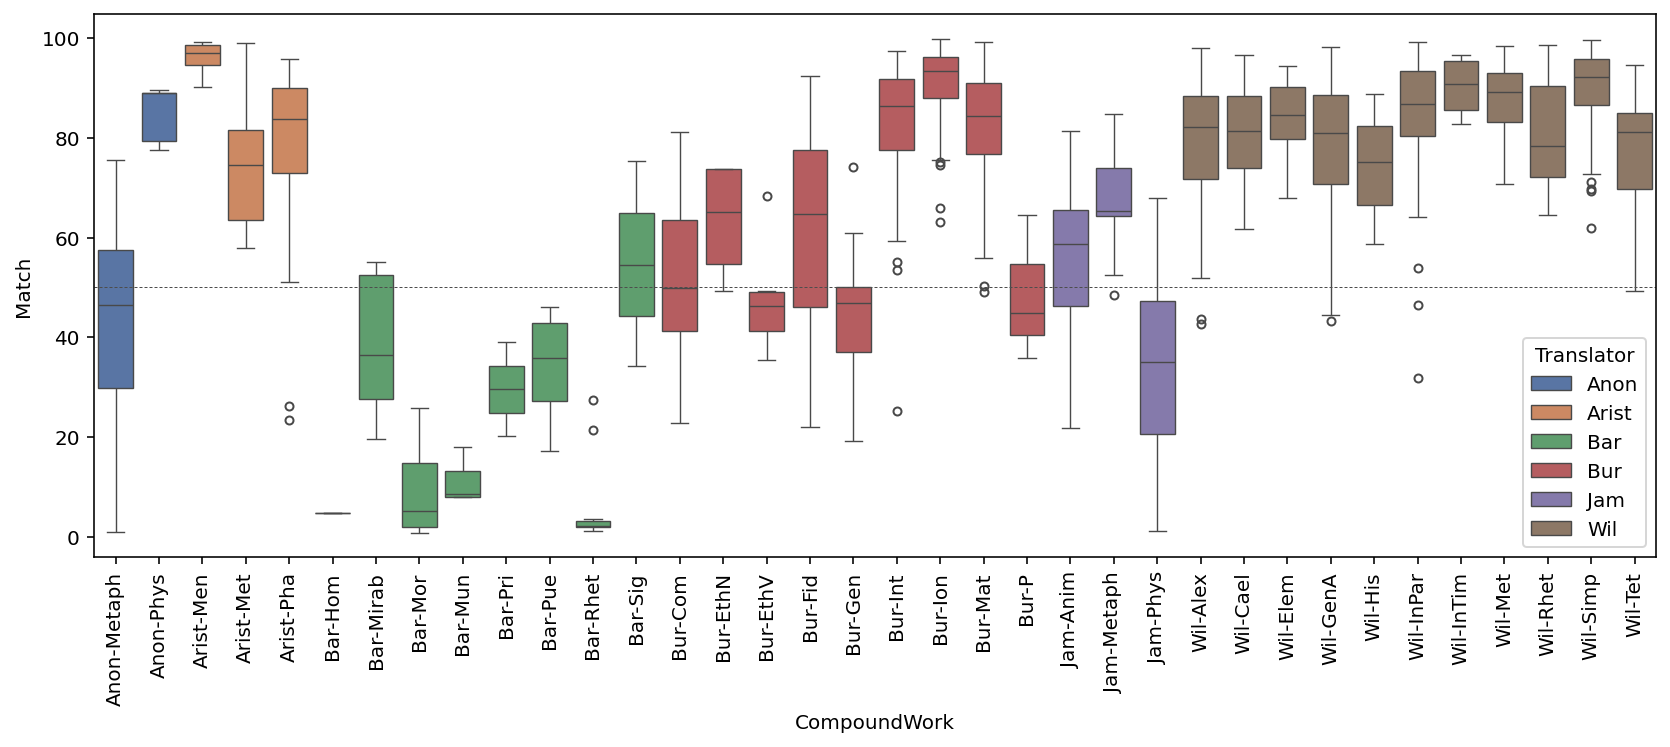

In [381]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.xticks(rotation=90)

sax = sns.boxplot(
    ax=ax,
    data=sbdf.sort_values(by="CompoundWork"),
    x="CompoundWork",
    y="Match",
    hue="Translator",
    linewidth=0.7,
    palette="deep",
    fliersize=4,
    flierprops={"marker": "o"},
)
sax.axhline(50, color=".3", dashes=(3, 2), linewidth=0.5)

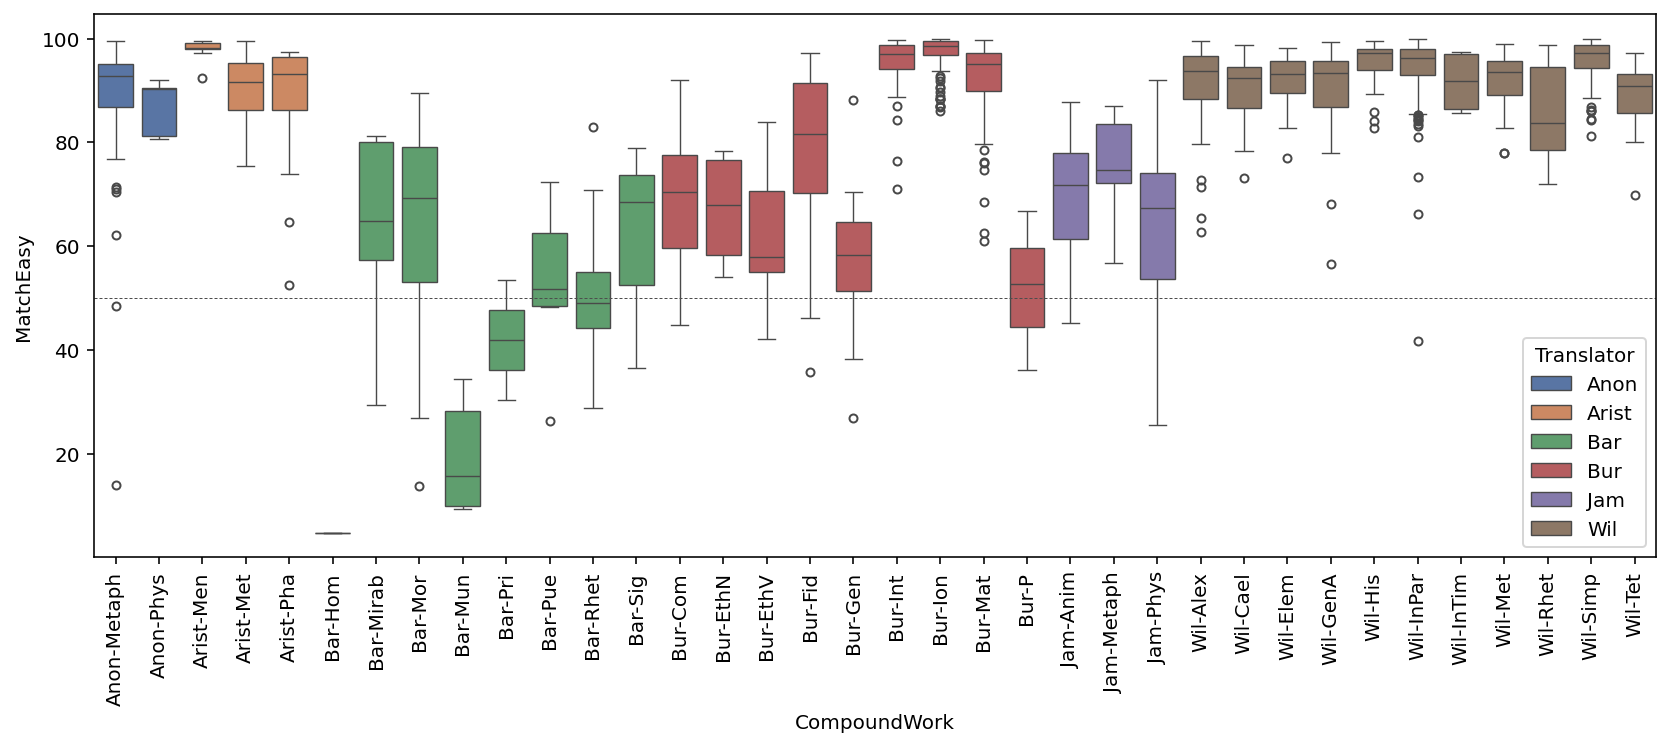

In [395]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.xticks(rotation=90)

sax = sns.boxplot(
    ax=ax,
    data=sbdf.sort_values(by="CompoundWork"),
    x="CompoundWork",
    y="MatchEasy",
    hue="Translator",
    linewidth=0.7,
    palette="deep",
    fliersize=4,
    flierprops={"marker": "o"},
)
sax.axhline(50, color=".3", dashes=(3, 2), linewidth=0.5)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Picking joint bandwidth of 5.19


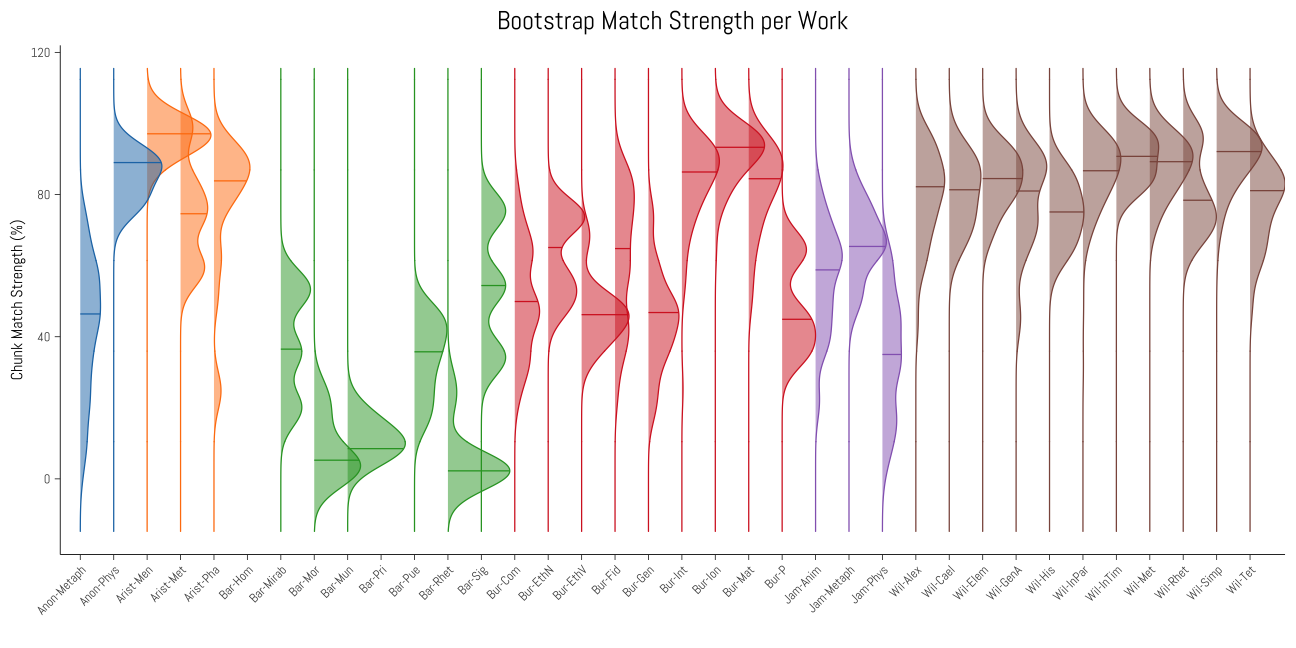

In [428]:
%%R -i sbdf -h 4.5 -w 9 -u in -r 144

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
font_add_google("Abel", "fnt")
showtext_auto()

df <- sbdf
plt <- "ggsci::category10_d3"
    
ggplot(df, aes(Match, CompoundWork, fill = Translator, color=Translator)) +
coord_cartesian(clip = "off") +
# geom_point(data=inliers, shape='|', size=5, position = position_nudge(y = -0.085), alpha=0.5) +
# geom_point(data=outliers, shape=1, size=1, stroke=0.2, position = position_nudge(y = -0.085),alpha=0.9) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    alpha = .5, size = 0.3
) +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
coord_flip() +
#scale_y_discrete(labels=c("French", "German", "Russian", "Shakespeare")) +
theme_bw() +
xlab("Chunk Match Strength (%)") +
ylab("") +
ggtitle("Bootstrap Match Strength per Work") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="fnt"),
    axis.text.x=element_text(angle = 45, hjust = 1),

)

In [397]:
%load_ext rpy2.ipython


In [543]:
last_try = full_disaster[(full_disaster.Work != "Hom")].reset_index(drop=True)

In [538]:
last_try = full_disaster.copy().reset_index(drop=True)

In [544]:
X = ss.transform(last_try[feat_cols])
y = np.array(lenc.transform(last_try.Translator))

In [471]:
import mapply

In [472]:
mapply.init(n_workers=-1)

In [545]:
last_try["Match"] = last_try.mapply(
    (lambda row: bs_row_harsh(row, last_try, X, y)), axis=1
)

100%|██████████| 11/11 [01:58<00:00, 10.75s/it]


In [551]:
last_try["CompoundWork"] = last_try.apply(
    lambda r: f"{r['Translator']}-{r['Work']}", axis=1
)

In [558]:
last_try = last_try[(last_try.Work != "Pri")].reset_index(drop=True)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.
In addition: Warning message:
Using alpha for a discrete variable is not advised. 
Picking joint bandwidth of 5.43


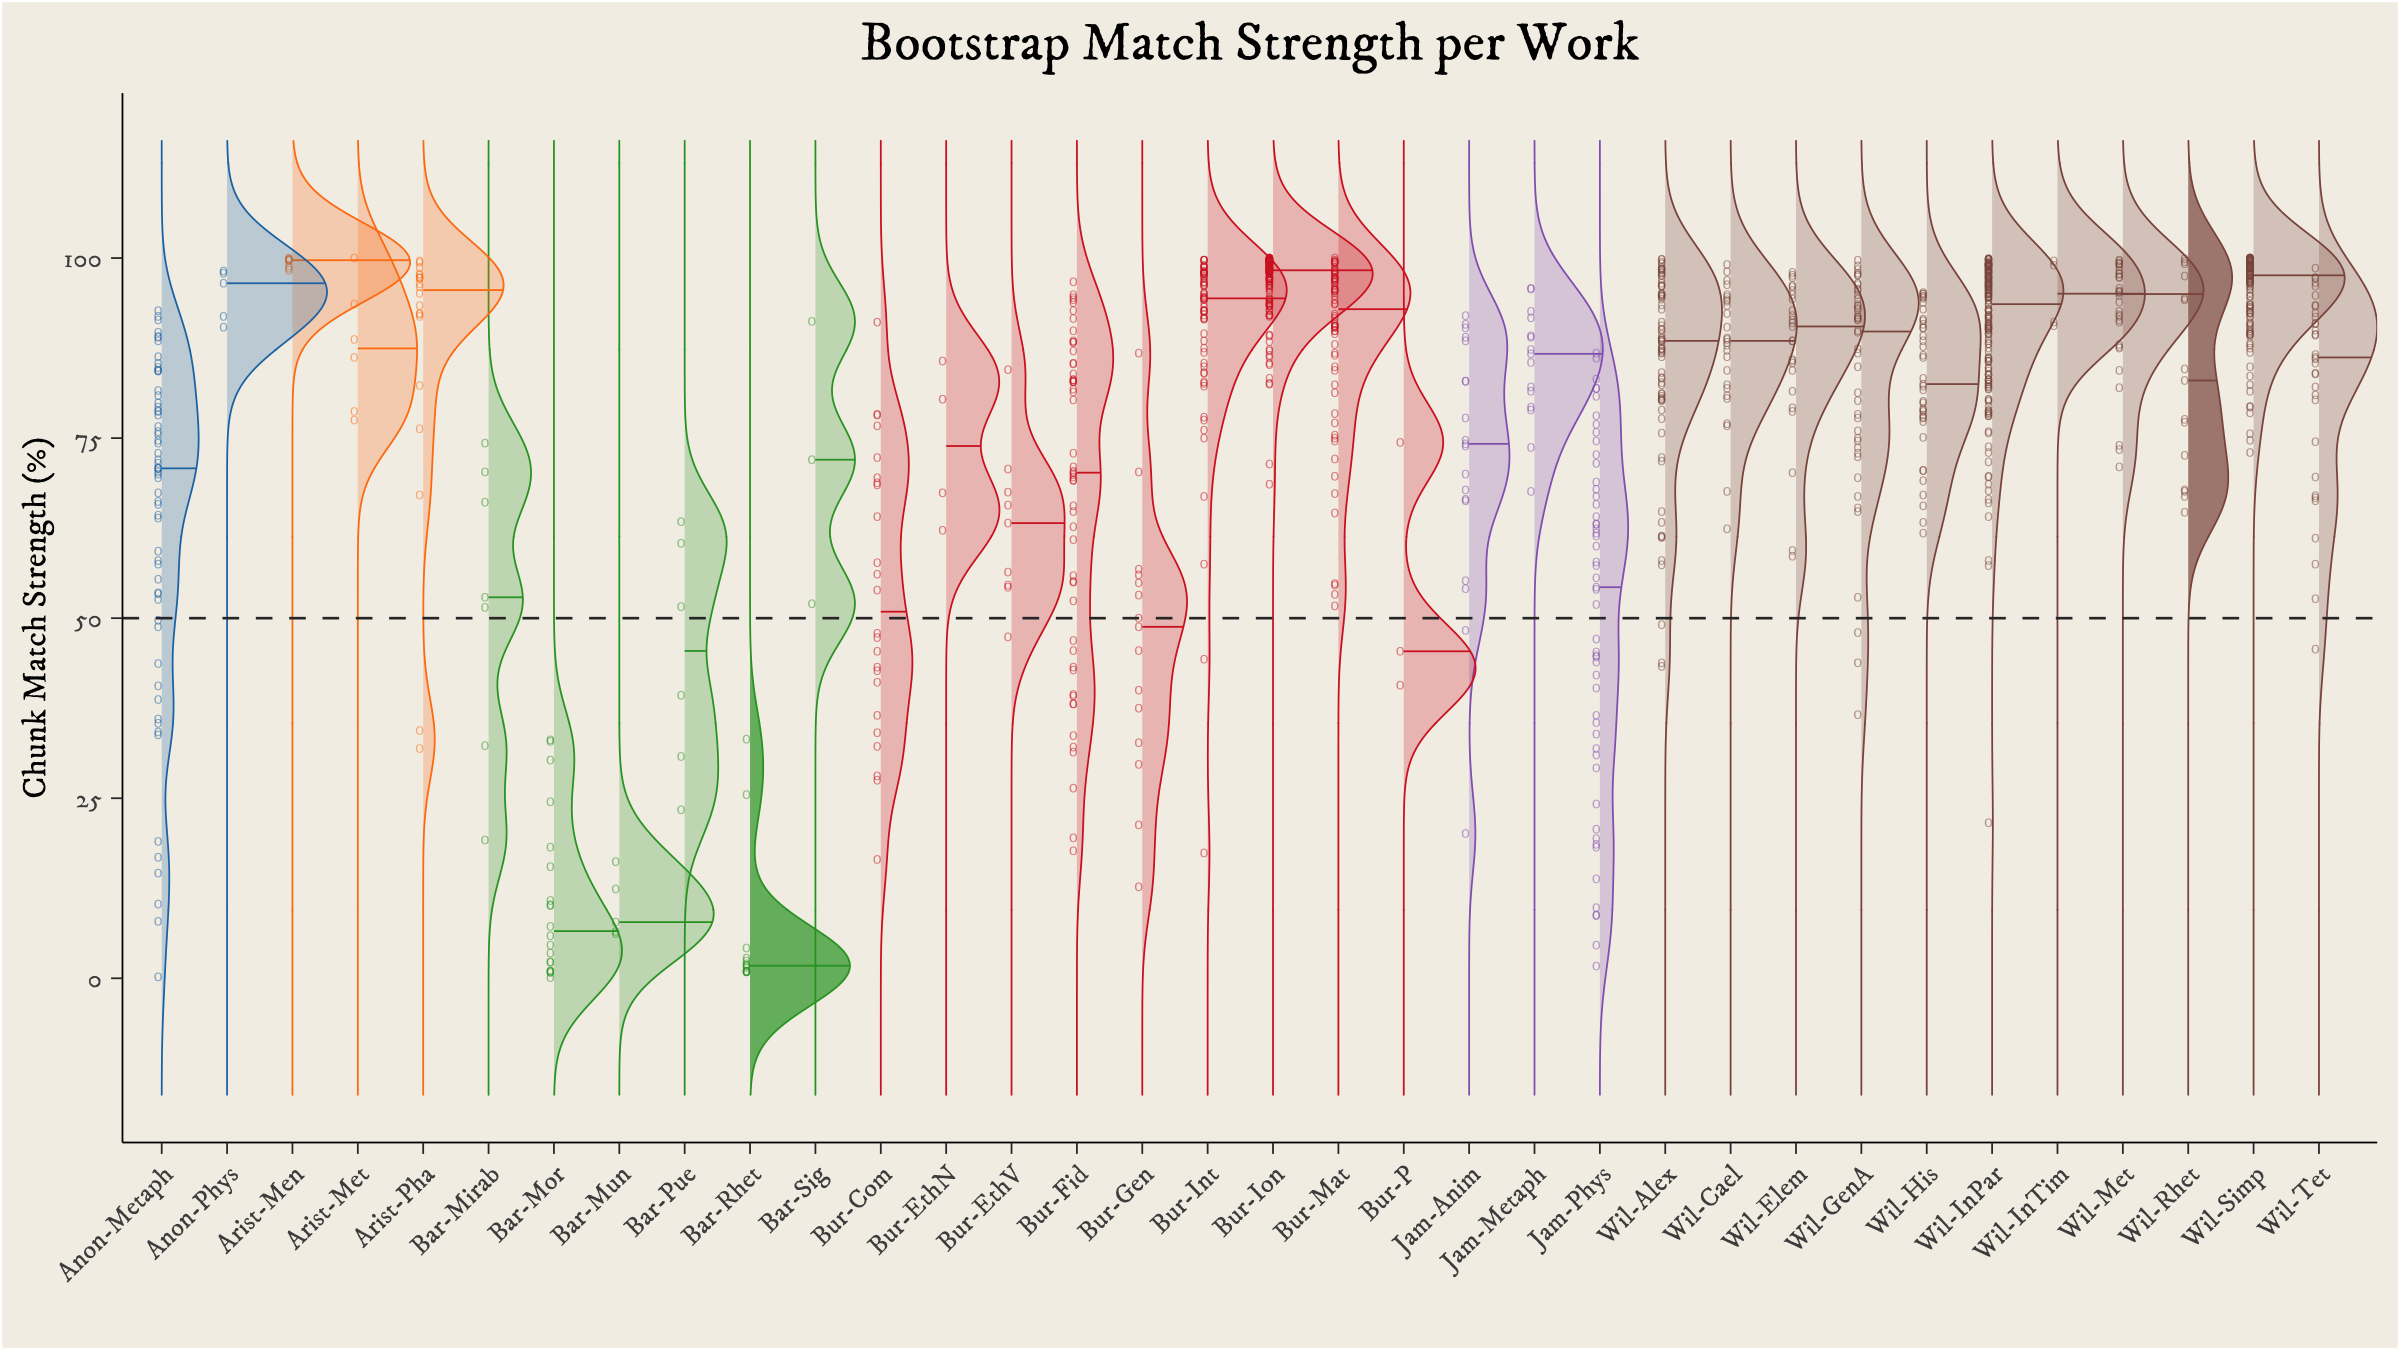

In [559]:
%%R -i last_try -h 4.5 -w 8 -u in -r 300

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
library(stringr)
library(dplyr)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

df <- last_try %>%
    mutate(rhet=str_detect(Work,'Rhet'))

plt <- "ggsci::category10_d3"
bgcol = '#f4f0e8' # antique paper

   
ggplot(df, aes(Match, CompoundWork, fill = Translator, color=Translator)) +
coord_cartesian(clip = "off") +
geom_point(shape='o', size=1, position = position_nudge(y = -0.055), alpha=0.5) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    aes(alpha = rhet), size = 0.2
) +
scale_alpha_discrete(range=c(0.25,0.7)) +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
scale_x_continuous(breaks=c(0,25,50,75,100)) +
geom_vline(xintercept=50, size=0.3, color='grey20', linetype='dashed') +
coord_flip() +
theme_bw() +
xlab("Chunk Match Strength (%)") +
ylab("") +
ggtitle("Bootstrap Match Strength per Work") +
theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="fnt"),
    axis.text.x=element_text(angle = 45, hjust = 1),

)